### <b>Urban delineation<b>
This notebook implements a GHSL settlement model algorithm as defined by the stage I of the Degree of Urbanisation (European Commission & Statistical Office of the European Union, 2021) and recommended by the UN STAT COM.
Model uses the population and built-up surface grid - European Commission, Joint Research Centre (JRC)<br> 
The method here implemented is described in detail bellow.

####  <b> GHSL - settlement model <b>
Delineate and classify settlement by typologies

#### Setlment L1 nomenclature:
##### Urban Centre - High Density Cluster (HDC)
##### Urban Cluster - Moderate Density Cluster (MDC) 

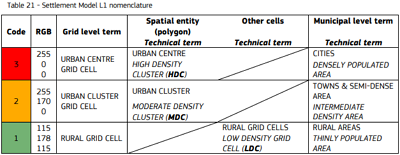

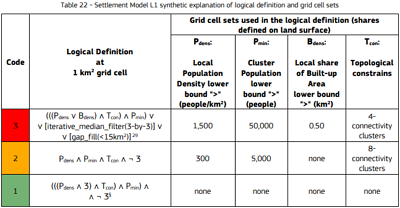
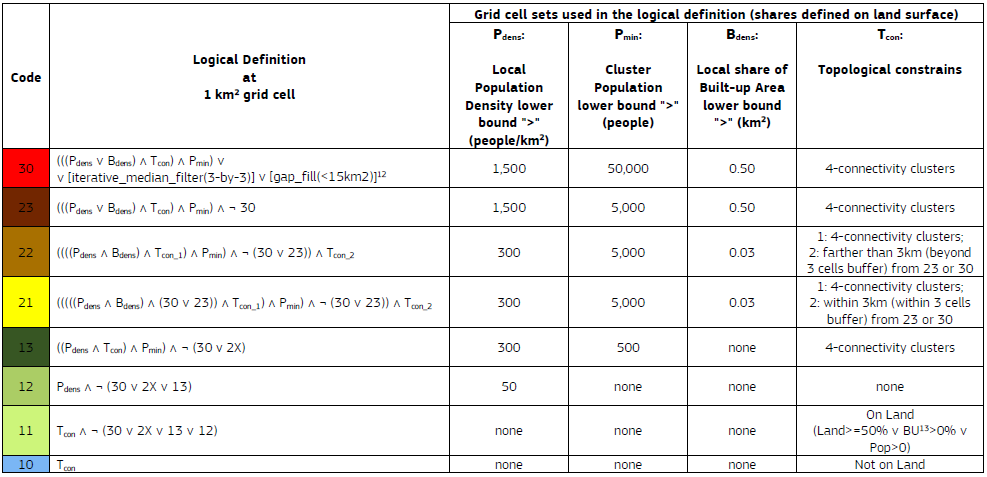

#### Setlment L2 nomenclature:
##### Urban Centre - High Density Cluster (HDC)
##### Dense Urban Cluster (DUC)
##### SemiDense Urban Cluster (SDUC)
##### Peri-Urban Cluster (PUC)

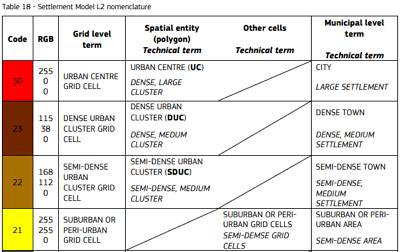
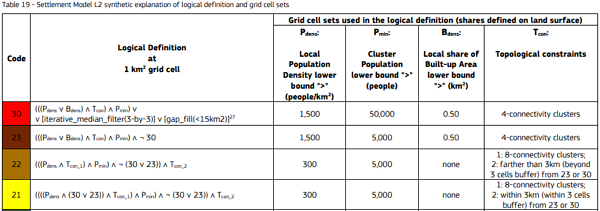

**GHSL data packages for settlement model:**<br>
<br>
built-up:
https://ghsl.jrc.ec.europa.eu/download.php?ds=bu
<br>
population:
https://ghsl.jrc.ec.europa.eu/download.php?ds=pop
<br>
<br>
Reference years: from 1975 to 2020, 5 years interval<br>
Resolution: 1km<br>
Coord. system: Mollweide<br>
Complete information about GHSL open data are available at:<br>
https://ghsl.jrc.ec.europa.eu/documents/GHSL_Data_Package_2022.pdf?t=1655995832
<br>
<br>

#### <b>Parameters by definition of GHSL settlement model L1 and L2<b>

<ul>   
<li>Threshold for total population per square kilometer : HDC_Pdens / MDC_Pdens </li>
<li>Threshold for population per cluster : HDC_Pmin / MDC_Pmin </li>  
<li>Threshold for % of built-up area : HDC_Bdens </li>
<li>Cluster connectivity : HDC_Tcon / MDC_Tcon </li>    
</ul>

##### <b>Constants : Pdens, Bdens, Pmin, Tcon<b>

In [1]:
# local population density (HDC: 1500 people/km2, MDC: 300 people/km2)
HDC_Pdens=1500
MDC_Pdens =300

# built-up area share > then
HDC_Bdens=500000 # (share of built-up area/km2: 0.5 => 500000 m2/km2)

# cluster populatin > then   (HDC: 50000 people, MDC: 5000 people)
HDC_Pmin=50000
MDC_Pmin=5000

# connectivity clusters
# Tcon=1 for 4-connectivity clusters, Tcon=2 for 8-connectivity clusters
HDC_Tcon=1 
MDC_Tcon=2 

# gap filling (<15km2)
HDC_GAPfill=15

#### <b>Load libraries:<b>

In [2]:
from xcube.core.store import new_data_store

import os
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, box

import xarray as xr
import rioxarray as rxr

import rasterio
import rasterio.features
from rasterio.features import shapes

from skimage import measure, morphology
from skimage.morphology import square
import scipy

import ipywidgets as widgets
import matplotlib.pyplot as plt

import folium
from folium import plugins
from branca.element import Figure

# from datetime import datetime

/opt/conda/envs/edc-default-2022.10-14/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


##### <b>location for results

In [3]:
# Create folder for result-data, if it doesn't exist:
Path(os.path.realpath('result-data')).mkdir(parents=True, exist_ok=True) 

In [4]:
output_dir = Path("/home/jovyan/result-data")
# print(datetime.utcnow())

In [5]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
# raise StopExecution

### <b>Select reference year and area of interest: <b>
  Before starts, the reference year and the area of interest needs to be defined.

In [6]:
# actual parameters
# reference year
REFyear = 2020
# aoi
aoi = "POLYGON ((19 48, 19 51, 12 51, 12 48, 19 48))"

#### <b>Reference year <b>  

In [7]:
# REFyear validity check:
# valid values from 1975 to 2020, 5 years interval:
REFyearVV=[1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]

if not REFyear in REFyearVV: #contains:
    print('! REFyear is out of range')
    raise StopExecution

#### <b>Area of interest <b>

In [8]:
# # # Select AOI by lat/lon coordinates -  example for area of Poland, Czechia and Slovakia:
# # x1 = 10  # degree (E-W)
# # y1 = 47 # degree (N-S)
# # x2 = 25  # degree (E-W)
# # y2 = 55 # degree (N-S)

# # Select AOI by lat/lon coordinates -  example for area of Czechia:
# x1 = 12  # degree (E-W)
# x2 = 19  # degree (E-W)
# y1 = 48 # degree (N-S)
# y2 = 51 # degree (N-S)

# aoi_centre = [(y2+y1)/2,(x2+x1)/2]
# bbox = x1, y1, x2, y2
# geom = box(*bbox)
# print(geom)

# AOI = gpd.GeoDataFrame({"id":1,"geometry":[geom]})
# AOI.set_crs(epsg=4326, inplace=True)  # WGS84
# AOI54009 = AOI.to_crs(crs='ESRI:54009')

# aoi=str(geom)
# print(aoi)

In [9]:
# AOI
# check selected aoi:
from shapely import wkt
import geopandas as gpd

polygon = wkt.loads(aoi)

AOI = gpd.GeoDataFrame({"id":1,"geometry":[polygon]})
AOI.set_crs(epsg=4326, inplace=True)  # WGS84
AOI54009 = AOI.to_crs(crs='ESRI:54009')

In [10]:
# fig = Figure(width=550, height=550)

# m = AOI.explore(style_kwds={'fillColor':'None','color':'blue','weight': 1}, name='aoi')

# lat_interval = 1
# lon_interval = 1

# # parallels:
# for lat in range(-90, 91, lat_interval):
#      folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# # meridians:
# for lon in range(-180, 181, lon_interval):
#     folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

# fig.add_child(m)
# m

### <b>Input data<b>

#### Open GHS built-up surface

In [11]:
BTU_data_store = new_data_store("s3", root="xcube-dcfs/GHSL/GHS-BUILT-S/",
                            storage_options=dict(anon=True) # anon=True - anonymous access (default False)
                           )

In [12]:
BTU_data_store_info = list(BTU_data_store.get_data_ids())
BTU_data_store_info

['GHS_BUILT_S_E1975_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E1980_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E1985_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E1990_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E1995_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E2000_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E2005_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E2010_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E2015_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_BUILT_S_E2020_GLOBE_R2022A_54009_1000_V1_0.tif']

In [13]:
# Select built-up data for Reference year
BTU_REFyear= '\n'.join(s for s in BTU_data_store_info if str(REFyear) in s)
# BTU_REFyear

In [14]:
# Info about built-up data for Reference year
BTU_data_store.describe_data(BTU_REFyear).to_dict()

{'data_id': 'GHS_BUILT_S_E2020_GLOBE_R2022A_54009_1000_V1_0.tif',
 'data_type': 'mldataset',
 'bbox': [-18041000.0, -9000000.0, 18041000.0, 9000000.0],
 'time_range': [None, None],
 'dims': {'x': 36082, 'y': 18000},
 'spatial_res': 1000.0,
 'coords': {'x': {'name': 'x', 'dtype': 'float64', 'dims': ['x']},
  'y': {'name': 'y', 'dtype': 'float64', 'dims': ['y']},
  'spatial_ref': {'name': 'spatial_ref',
   'dtype': 'int64',
   'dims': [],
   'attrs': {'crs_wkt': 'PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]',
    'spatial_ref': 'PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHOR

In [15]:
# # Info about population data for Reference year
# print(BTU_data_store.open_data(BTU_REFyear).num_levels, '\n')
# print(BTU_data_store.open_data(BTU_REFyear).datasets, '\n')
# BTU_data_store.open_data(BTU_REFyear).grid_mapping

In [16]:
level = 0   # this is the highest resolution, which corresponds to 1km

# Build-up dataset for selected Reference year - clipped by AOI
BTU_ds_0 = BTU_data_store.open_data(BTU_REFyear).get_dataset(level).rio.clip(AOI54009.geometry, AOI54009.crs)
BTU_ds_0 = BTU_ds_0.rename({"band_1": "built-up"})
#BTU_ds_0

#### Open GHS population grid 

In [17]:
POP_data_store = new_data_store("s3", 
                            root="xcube-dcfs/GHSL/GHS-POP/",
                            storage_options=dict(anon=True)
                           )

OP_data_store info:

In [18]:
POP_data_store_info=list(POP_data_store.get_data_ids())
POP_data_store_info

['GHS_POP_E1975_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E1980_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E1985_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E1990_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E1995_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E2000_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E2005_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E2010_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E2015_GLOBE_R2022A_54009_1000_V1_0.tif',
 'GHS_POP_E2020_GLOBE_R2022A_54009_1000_V1_0.tif']

In [19]:
# Select population data for Reference year
POP_REFyear= '\n'.join(s for s in POP_data_store_info if str(REFyear) in s)
#POP_REFyear

In [20]:
# Info about built-up data for Reference year
POP_data_store.describe_data(POP_REFyear).to_dict()

{'data_id': 'GHS_POP_E2020_GLOBE_R2022A_54009_1000_V1_0.tif',
 'data_type': 'mldataset',
 'bbox': [-18041000.0, -9000000.0, 18041000.0, 9000000.0],
 'time_range': [None, None],
 'dims': {'x': 36082, 'y': 18000},
 'spatial_res': 1000.0,
 'coords': {'x': {'name': 'x', 'dtype': 'float64', 'dims': ['x']},
  'y': {'name': 'y', 'dtype': 'float64', 'dims': ['y']},
  'spatial_ref': {'name': 'spatial_ref',
   'dtype': 'int64',
   'dims': [],
   'attrs': {'crs_wkt': 'PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]',
    'spatial_ref': 'PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY[

In [21]:
level = 0   # this is the highest resolution, which corresponds to 1km

# Population dataset  for selected Reference year - clipped by AOI
POP_ds_0 = POP_data_store.open_data(POP_REFyear).get_dataset(level).rio.clip(AOI54009.geometry, AOI54009.crs)
POP_ds_0 = POP_ds_0.rename({"band_1": "population_grid"})
#POP_ds_0

#### Dataset to DataArray

In [22]:
BTU_da=(BTU_ds_0['built-up']).squeeze()
BTU_da = BTU_da.load()
BTU_da=BTU_da.where(BTU_da != BTU_da.attrs['_FillValue']).fillna(0)
BTU_da

<xarray.DataArray 'built-up' (y: 316, x: 581)>
array([[11411.,   601.,     0., ...,     0.,     0.,     0.],
       [  104.,     0.,     0., ...,     0.,     0.,     0.],
       [20716.,    51.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])
Coordinates:
  * x            (x) float64 9.015e+05 9.025e+05 ... 1.48e+06 1.482e+06
  * y            (y) float64 5.978e+06 5.976e+06 ... 5.664e+06 5.662e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    grid_mapping:   spatial_ref
    _FillValue:     4294967295

In [23]:
POP_da=(POP_ds_0['population_grid']).squeeze()
POP_da = POP_da.load()
POP_da=POP_da.where(POP_da != POP_da.attrs['_FillValue']).fillna(0)
POP_da

<xarray.DataArray 'population_grid' (y: 316, x: 581)>
array([[ 50.13442452,   2.64050382,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.64025903,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [124.233161  ,   0.22406937,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
  * x            (x) float64 9.015e+05 9.025e+05 ... 1.48e+06 1.482e+06
  * y            (y) float64 5.978e+06 5.976e+06 ... 5.664e+06 5.662e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_COVARIANCES:    330985.3282731281
    STATISTICS_MAXIMUM:        615756.8270821
    STATISTICS_MEAN:           56.450798856297
    STATISTICS_MEDIAN:         0.0
    STATISTICS_MINIMUM:        0
    STATISTICS_SKIPFACTORX:    1
    STATISTICS_SKIPFACTORY:    1
    STATISTICS_STDDEV:         575.31324361006
    STATISTICS_VALID_PERCENT:  21.26
    scale_factor:              1.0
    add_offset:                0.0
    grid_mapping:              spatial_ref
    _FillValue:                -200.0

###  <b>L1: Urban Centre (HDC) and Urban Cluster (MDC)<b>

#### step1: built-up and population data - binary masks  by model definition

In [24]:
# HDC
# built-up area
HDC_BTU_mask = 1 * np.ones_like(BTU_da) * (BTU_da > HDC_Bdens).astype(np.int8)  # HDC_Bdens (share of built-up area/km2: 0.5 => 500000 m2/km2)
# population
HDC_POP_mask = 1 * np.ones_like(POP_da) * (POP_da > HDC_Pdens).astype(np.int8) # HDC_Pdens >=1500 inh/km2
HDC_UC01_mask = HDC_BTU_mask + HDC_POP_mask

# MDC
MDC_POP_mask = 1 * np.ones_like(POP_da) * (POP_da > MDC_Pdens).astype(np.int8) # MDC_Pdens >=300  inh/km2

In [25]:
# BINARY MASK:
HDC_UC01_mask = 1 * np.ones_like(HDC_UC01_mask) * (HDC_UC01_mask> 0).astype(np.int8)
MDC_UC01_mask = MDC_POP_mask

#### step2: cluster connectivity
https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label

In [26]:
# 4/8-connectivity regions:
# HDC_Tcon=1 for 4-connectivity clusters
# MDC_Tcon=2 for 8-connectivity clusters

HDC_UC02_4conn = measure.label(HDC_UC01_mask, background=0, return_num=False, connectivity=HDC_Tcon)
# print('HDC number of regions:', HDC_UC02_4conn.max())

MDC_UC02_8conn = measure.label(MDC_UC01_mask, background=0, return_num=False, connectivity=MDC_Tcon)
# print('MDC number of regions:', MDC_UC02_8conn.max())

#### step3: total population in cluster

In [27]:
HDC_UC03=np.zeros_like(HDC_POP_mask).astype('int')

POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, HDC_UC02_4conn.max()):
    POPregionID=((HDC_UC02_4conn == regionID).astype('int')) * POP_da.data    
    # threshold for population in cluster > 50000
    if POPregionID.sum() > HDC_Pmin:
        POPregionSUM.append(int(round(POPregionID.sum())))
        POPregionIDsum.append(regionID)
        HDC_UC03=HDC_UC03+np.where(HDC_UC02_4conn == regionID, HDC_UC02_4conn, 0)

In [28]:
MDC_UC03=np.zeros_like(MDC_POP_mask).astype('int')

POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, MDC_UC02_8conn.max()):
    POPregionID=((MDC_UC02_8conn == regionID).astype('int')) * POP_da.data    
    # threshold for population in cluster > 5000
    if POPregionID.sum() > MDC_Pmin:
        POPregionSUM.append(int(round(POPregionID.sum())))
        POPregionIDsum.append(regionID)
        MDC_UC03=MDC_UC03+np.where(MDC_UC02_8conn == regionID, MDC_UC02_8conn, 0)

### L1: Urban Center (HDC)

#### step4: Urban Centre (HDC) - gaps filling < 15km2

inverse raster / gaps

In [29]:
HDC_UC03_BIN=np.where(HDC_UC03 > 0, 1, 0)
HDC_UC03_INV=np.where(HDC_UC03_BIN == 1, 0, 1)

HDC_UC03_INV = measure.label(HDC_UC03_INV, background=0, connectivity=2) # 8-connectivity
# number of holes
# HDC_UC03_INV.max()

gaps filling

In [30]:
unique, counts = np.unique(HDC_UC03_INV, return_counts=True,)
gaps=list(zip(unique, counts)) 
#print(gaps)

for gap in gaps:
    if gap[1] < HDC_GAPfill:
        gapID=(HDC_UC03_INV == gap[0]).astype(int)        
        HDC_UC03_BIN=HDC_UC03_BIN+gapID

regions where POP > 50000 with filled gaps < 15km2 

In [31]:
HDC_UC03_4conn = measure.label(HDC_UC03_BIN, background=0, connectivity=HDC_Tcon)  # connectivity=HDC_Tcon
print(HDC_UC03_4conn.min(),HDC_UC03_4conn.max())

0 25


In [32]:
# binary raster
HDC_UC04_BIN=np.where(HDC_UC03_4conn >= 1, 1, 0)
print(HDC_UC04_BIN.sum())

1610


#### step5: Urban Centre (HDC) - morphology

closing, erosion, dilatation

In [33]:
HDC_UC04=np.zeros_like(HDC_UC03_BIN).astype('int')
# regiony sa vyhodnocuju sekvencne v cykle:
POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, HDC_UC03_4conn.max()):
    # mask 0-1 for region, # POP in region
    POPregionID=((HDC_UC03_4conn == regionID).astype('int'))  
    #print(POPregionID.min(), POPregionID.max(), POPregionID.sum())
    POPregionID = morphology.binary_closing(POPregionID, square(3))
    POPregionID= morphology.binary_dilation(POPregionID)
    POPregionID= morphology.binary_erosion(POPregionID)
    #POPregionID = skimage.morphology.binary_closing(POPregionID, square(3))
    HDC_UC04=HDC_UC04+POPregionID
    #print(HDC_UC05.sum())

In [34]:
# gaps filling after morphology:
HDC_UC04_INV=np.where(HDC_UC04 == 1, 0, 1)
HDC_UC04_INV = measure.label(HDC_UC04_INV, background=0, connectivity=2)
# number of holes
HDC_UC04_INV.max()

2

In [35]:
unique1, counts1 = np.unique(HDC_UC04_INV, return_counts=True,)
gaps1 = [x for x in zip(unique1, counts1) if x[1] < HDC_GAPfill]
#print(gaps1)

for gap1 in gaps1:
    gapID1=(HDC_UC04_INV == gap1[0]).astype(int)
    HDC_UC04=HDC_UC04+gapID1

In [36]:
HDC_UC04_4conn = measure.label(HDC_UC04, background=0, connectivity=HDC_Tcon)
HDC_UC04_4conn.max()

24

In [37]:
# binary raster
HDC_UC04_4conn_BIN=np.where(HDC_UC04_4conn >= 1, 1, 0)
HDC_UC04_4conn_BIN.sum()

1757

### L1: Urban Cluster (MDC)

In [38]:
# binary
MDC_UC03=np.where(MDC_UC03 > 0, 1, 0)
# 
MDC_UC04=MDC_UC03-HDC_UC04
MDC_UC04=np.where(MDC_UC04 == 1, 1, 0)

In [39]:
MDC_UC04_8conn = measure.label(MDC_UC04, background=0, connectivity=MDC_Tcon)
print(MDC_UC04_8conn.min(),MDC_UC04_8conn.max())

0 459


\
HDC and MDC to vector

HDC:  numpy.ndarray to DataArray

In [40]:
HDC_UC05 = xr.DataArray(
    data=HDC_UC04_4conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='urban_centre',
    )

HDC_UC05=HDC_UC05.astype(np.int16)
HDC_UC05

<xarray.DataArray 'urban_centre' (y: 316, x: 581)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * x            (x) float64 9.015e+05 9.025e+05 ... 1.48e+06 1.482e+06
  * y            (y) float64 5.978e+06 5.976e+06 ... 5.664e+06 5.662e+06
    spatial_ref  int64 0

HDC: export to vector

In [41]:
# mask=None
mask=HDC_UC05.data != 0
with HDC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=4, transform=HDC_UC05.rio.transform())))

geoms = list(results)
# first feature
# print(geoms[0])

In [42]:
HDC_UrbanCentre  = gpd.GeoDataFrame.from_features(geoms)
HDC_UrbanCentre.crs=HDC_UC05.rio.crs
HDC_UrbanCentre.raster_val=HDC_UrbanCentre.raster_val.astype('int')
HDC_UrbanCentre.rename(columns={'raster_val':'hdcid'}, inplace=True)
HDC_UrbanCentre['area_km2'] = HDC_UrbanCentre['geometry'].area/ 10**6
HDC_UrbanCentre['code']=3
HDC_UrbanCentre.sort_values(['area_km2'],ascending=False).head(3)

,geometry,hdcid,area_km2,code
23,"POLYGON ((1273000.000 5695000.000, 1277000.000...",24,349.0,3
11,"POLYGON ((1102000.000 5891000.000, 1103000.000...",10,330.0,3
7,"POLYGON ((1423000.000 5916000.000, 1424000.000...",6,287.0,3


MDC:  numpy.ndarray to DataArray

In [43]:
MDC_UC05 = xr.DataArray(
    data=MDC_UC04_8conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='urban_cluster',
    )

MDC_UC05=MDC_UC05.astype(np.int16)
MDC_UC05

<xarray.DataArray 'urban_cluster' (y: 316, x: 581)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * x            (x) float64 9.015e+05 9.025e+05 ... 1.48e+06 1.482e+06
  * y            (y) float64 5.978e+06 5.976e+06 ... 5.664e+06 5.662e+06
    spatial_ref  int64 0

MDC: export to vector

In [44]:
# mask=None
mask=MDC_UC05.data != 0
with MDC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=8, transform=MDC_UC05.rio.transform())))

geoms = list(results)

In [45]:
MDC_UrbanCluster  = gpd.GeoDataFrame.from_features(geoms)
MDC_UrbanCluster.crs=MDC_UC05.rio.crs
MDC_UrbanCluster.raster_val=MDC_UrbanCluster.raster_val.astype('int')
MDC_UrbanCluster.rename(columns={'raster_val':'mdcid'}, inplace=True)
MDC_UrbanCluster["area_km2"] = MDC_UrbanCluster['geometry'].area/ 10**6
MDC_UrbanCluster['code']=2
MDC_UrbanCluster.sort_values(['area_km2'],ascending=False).head(3)

,geometry,mdcid,area_km2,code
237,"POLYGON ((1407000.000 5892000.000, 1408000.000...",154,849.0,2
198,"POLYGON ((1111000.000 5885000.000, 1112000.000...",162,265.0,2
155,"POLYGON ((1417000.000 5907000.000, 1419000.000...",128,223.0,2


### HDC and MDC export to shapefiles

In [46]:
# EXPORT 2 shapefile World Mollweide (ESRI:54009)
# HDC_UrbanCentre.to_file(os.path.join(output_dir,'HDC_UrbanCentre_ESRI54009_'+str(REFyear)+'.shp'))
# Export to shapefile WGS84 (EPSG:4326 )
HDC_UrbanCentre.to_crs(epsg=4326).to_file(os.path.join(output_dir,'HDC_UrbanCentre_EPSG4326_'+str(REFyear)+'.shp'))

# EXPORT 2 shapefile World Mollweide (ESRI:54009)
# MDC_UrbanCluster.to_file(os.path.join(output_dir,'MDC_UrbanCluster_ESRI54009_'+str(REFyear)+'.shp'))
# Export to shapefile WGS84 (EPSG:4326 )
MDC_UrbanCluster.to_crs(epsg=4326).to_file(os.path.join(output_dir,'MDC_UrbanCluster_EPSG4326_'+str(REFyear)+'.shp'))

# print(datetime.utcnow())

### L1: Visualization of results

In [47]:
# fig = Figure(width=600, height=600)

# m = AOI54009.explore(style_kwds={'fillColor':'None','color':'blue','weight': 1}, name='aoi')

# lat_interval = 1
# lon_interval = 1

# # parallels:
# for lat in range(-90, 91, lat_interval):
#      folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# # meridianss:
# for lon in range(-180, 181, lon_interval):
#     folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

# MDC_UrbanCluster.explore(m=m,style_kwds={'fillColor':'orange','color':'orange','weight': 1}, name='MDC_UrbanCluster')
# HDC_UrbanCentre.explore(m=m,style_kwds={'fillColor':'red','color':'red','weight': 1.5}, name='HDC_UrbanCentre')

# folium.LayerControl('topright',collapsed=True).add_to(m)
# minimap = plugins.MiniMap(height=90, width=90, zoom_level_offset=-7)
# m.add_child(minimap)

# fig.add_child(m)
# m

### <b>L2: Dense Urban Cluster (DUC), Semi-Dense Urban Cluster (SDUC) and  Peri-Urban Cluster (PUC)<b>

### step1: Dense Urban Cluster (DUC)

In [48]:
# MASK
DUC_mask=HDC_UC01_mask  
#print(DUC_mask.sum())

In [49]:
# CONNECTIVITY
DUC_4conn = measure.label(DUC_mask, background=0, return_num=False, connectivity=HDC_Tcon) #.squeeze()
print('DUC number of regions:', DUC_4conn.max())

DUC number of regions: 674


In [50]:
# TOTAL POPULATION IN CLUSTER
DUC_UC03=np.zeros_like(HDC_POP_mask).astype('int')

POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, DUC_4conn.max()):
    POPregionID=((DUC_4conn == regionID).astype('int')) * POP_da.data    
    # threshold for population in cluster > 5000
    if POPregionID.sum() > MDC_Pmin:
        POPregionSUM.append(int(round(POPregionID.sum())))
        POPregionIDsum.append(regionID)
        DUC_UC03=DUC_UC03+np.where(DUC_4conn == regionID, DUC_4conn, 0)

In [51]:
# SUBTRACTION OF HDC
DUC_UC03_BIN=np.where(DUC_UC03 > 0, 1, 0)
DUC_UC03_BIN=DUC_UC03_BIN-HDC_UC04_4conn_BIN
DUC_UC03_BIN=np.where(DUC_UC03_BIN >0, 1, 0)
print(DUC_UC03_BIN.sum())

1370


In [52]:
# CONNECTIVITY
DUC_UC04_4conn = measure.label(DUC_UC03_BIN, background=0, connectivity=HDC_Tcon)  # connectivity=HDC_Tcon
print(DUC_UC04_4conn.min(),DUC_UC04_4conn.max())

0 216


In [53]:
# BINARY MASK
DUC_UC04_4conn_BIN=np.where(DUC_UC04_4conn > 0, 1, 0)
DUC_UC04_4conn_BIN.sum()

1370

DUC:  numpy.ndarray to DataArray

In [54]:
DUC_UC05 = xr.DataArray(
    data=DUC_UC04_4conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='dense_urban_cluster',
    )

DUC_UC05=DUC_UC05.astype(np.int16)
DUC_UC05

<xarray.DataArray 'dense_urban_cluster' (y: 316, x: 581)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * x            (x) float64 9.015e+05 9.025e+05 ... 1.48e+06 1.482e+06
  * y            (y) float64 5.978e+06 5.976e+06 ... 5.664e+06 5.662e+06
    spatial_ref  int64 0

DUC: export to vector

In [55]:
# mask=None
mask=DUC_UC05.data != 0
with DUC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=4, transform=DUC_UC05.rio.transform())))

geoms = list(results)

In [56]:
DUC_DenseUrbanCluster  = gpd.GeoDataFrame.from_features(geoms)
DUC_DenseUrbanCluster.crs=DUC_UC05.rio.crs
DUC_DenseUrbanCluster.raster_val=DUC_DenseUrbanCluster.raster_val.astype('int')
DUC_DenseUrbanCluster.rename(columns={'raster_val':'ducid'}, inplace=True)
DUC_DenseUrbanCluster['code']=23

### step2: Semi-Dense Urban Cluster (SDUC)

In [57]:
# MASK
SDUC_mask=MDC_UC01_mask 
print(DUC_mask.sum())

<xarray.DataArray ()>
array(3401.)
Coordinates:
    spatial_ref  int64 0


In [58]:
# CONNECTIVITY
SDUC_8conn = measure.label(SDUC_mask, background=0, return_num=False, connectivity=MDC_Tcon) # 8-connectivity cluster
print('SDUC number of regions:', SDUC_8conn.max())

SDUC number of regions: 4003


In [59]:
# TOTAL POPULATION IN CLUSTER
SDUC_UC03=np.zeros_like(HDC_POP_mask).astype('int')

POPregionIDsum=[]
POPregionSUM=[]
for regionID in range(1, SDUC_8conn.max()):
    POPregionID=((SDUC_8conn == regionID).astype('int')) * POP_da.data    
    # threshold for population in cluster > 5000
    if POPregionID.sum() > MDC_Pmin:
        POPregionSUM.append(int(round(POPregionID.sum())))
        POPregionIDsum.append(regionID)
        SDUC_UC03=SDUC_UC03+np.where(SDUC_8conn == regionID, SDUC_8conn, 0)

In [60]:
# Minus HDC and DUC
SDUC_UC03_BIN=np.where(SDUC_UC03 > 0, 1, 0)
SDUC_UC03_BIN=SDUC_UC03_BIN - HDC_UC04_4conn_BIN - DUC_UC04_4conn_BIN
SDUC_UC03_BIN=np.where(SDUC_UC03_BIN >0, 1, 0)
print(SDUC_UC03_BIN.sum())

8822


In [61]:
SDUC_UC04_8conn = measure.label(SDUC_UC03_BIN, background=0, connectivity=MDC_Tcon)  # connectivity=HDC_Tcon
print(SDUC_UC04_8conn.min(),SDUC_UC04_8conn.max())

0 631


In [62]:
SDUC_UC05 = xr.DataArray(
    data=SDUC_UC04_8conn,
    dims=BTU_da.dims,
    coords=BTU_da.coords,
    name='semidense_urban_cluster',
    )

SDUC_UC05=SDUC_UC05.astype(np.int16)
SDUC_UC05

<xarray.DataArray 'semidense_urban_cluster' (y: 316, x: 581)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * x            (x) float64 9.015e+05 9.025e+05 ... 1.48e+06 1.482e+06
  * y            (y) float64 5.978e+06 5.976e+06 ... 5.664e+06 5.662e+06
    spatial_ref  int64 0

SDUC: export to vector

In [63]:
# mask=None
mask=SDUC_UC05.data != 0
with SDUC_UC05 as src:
    image = src.data # first band
    results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for i, (s, v) 
    in enumerate(
        shapes(image, mask=mask, connectivity=8, transform=SDUC_UC05.rio.transform())))

geoms = list(results)
# first feature
# print(geoms[0])

In [64]:
SDUC_SemiDenseUrbanCluster_temp  = gpd.GeoDataFrame.from_features(geoms)
SDUC_SemiDenseUrbanCluster_temp.crs=SDUC_UC05.rio.crs
SDUC_SemiDenseUrbanCluster_temp.raster_val=SDUC_SemiDenseUrbanCluster_temp.raster_val.astype('int')
SDUC_SemiDenseUrbanCluster_temp.rename(columns={'raster_val':'sducid'}, inplace=True)
SDUC_SemiDenseUrbanCluster_temp['code']=22

In [65]:
# HDC & DUC - BUFFER 3km 
res_union_buffer = gpd.overlay(HDC_UrbanCentre[['geometry']], DUC_DenseUrbanCluster[['geometry']], how='union',keep_geom_type=True).buffer(3000).unary_union

res_union_buffer =gpd.GeoSeries(res_union_buffer)
res_union_buffer = gpd.GeoDataFrame(geometry=gpd.GeoSeries(res_union_buffer))
res_union_buffer.crs=HDC_UrbanCentre.crs
res_union_buffer[['buff3']]=1

In [66]:
# sjoin with buffer
SDUC_SemiDenseUrbanCluster_temp = gpd.sjoin(SDUC_SemiDenseUrbanCluster_temp, res_union_buffer[['buff3', 'geometry']], how='left',predicate='intersects')
SDUC_SemiDenseUrbanCluster_temp.drop(columns =['index_right'],inplace=True)
SDUC_SemiDenseUrbanCluster_temp['code'] = np.where(SDUC_SemiDenseUrbanCluster_temp['buff3'] == 1, 21, 22)
# print(SDUC_SemiDenseUrbanCluster_temp.tail(2))

In [67]:
# SDUC_SemiDenseUrbanCluster
SDUC_SemiDenseUrbanCluster = SDUC_SemiDenseUrbanCluster_temp[SDUC_SemiDenseUrbanCluster_temp.code == 22].drop(columns=['buff3'])

### step3: Peri-Urban Cluster (PUC)

In [68]:
# PUC_PeriUrbanCluster
PUC_PeriUrbanCluster = SDUC_SemiDenseUrbanCluster_temp[SDUC_SemiDenseUrbanCluster_temp.code == 21].drop(columns=['buff3'])
PUC_PeriUrbanCluster.rename(columns={'sducid':'pucid'},inplace=True)

### DUC, SDUC and PUC export to shapefile

DUC: export to shapefile

In [69]:
# EXPORT 2 shapefile World Mollweide (ESRI:54009)
# DUC_DenseUrbanCluster.to_file(os.path.join(output_dir,'DUC_DenseUrbanCluster_ESRI54009_'+str(REFyear)+'.shp'))

# Export to shapefile WGS84 (EPSG:4326 )
DUC_DenseUrbanCluster.to_crs(epsg=4326).to_file(os.path.join(output_dir,'DUC_DenseUrbanCluster_EPSG4326_'+str(REFyear)+'.shp'))
# print(datetime.utcnow())

SDUC: export to shapefile

In [70]:
# EXPORT 2 shapefile World Mollweide (ESRI:54009)
# SDUC_SemiDenseUrbanCluster.to_file(os.path.join(output_dir,'SDUC_SemiDenseUrbanCluster_ESRI54009_'+str(REFyear)+'.shp'))

# Export to shapefile WGS84 (EPSG:4326 )
SDUC_SemiDenseUrbanCluster.to_crs(epsg=4326).to_file(os.path.join(output_dir,'SDUC_SemiDenseUrbanCluster_EPSG4326_'+str(REFyear)+'.shp'))
# print(datetime.utcnow())

PUC: export to shapefile

In [71]:
# EXPORT 2 shapefile World Mollweide (ESRI:54009)
# PUC_PeriUrbanCluster.to_file(os.path.join(output_dir,'PUC_PeriUrbanCluster_ESRI54009_'+str(REFyear)+'.shp'))

# Export to shapefile WGS84 (EPSG:4326 )
PUC_PeriUrbanCluster.to_crs(epsg=4326).to_file(os.path.join(output_dir,'PUC_PeriUrbanCluster_EPSG4326'+str(REFyear)+'.shp'))
# print(datetime.utcnow())

### L2: Visualization of results

In [72]:
fig = Figure(width=600, height=600)

m = AOI54009.explore(style_kwds={'fillColor':'None','color':'blue','weight': 1}, name='aoi')

lat_interval = 1
lon_interval = 1

# parallels:
for lat in range(-90, 91, lat_interval):
     folium.PolyLine([[lat, -180],[lat, 180]], weight=0.5).add_to(m)
# meridianss:
for lon in range(-180, 181, lon_interval):
    folium.PolyLine([[-90, lon],[90, lon]], weight=0.5).add_to(m)

PUC_PeriUrbanCluster.explore(m=m,style_kwds={'fillColor':'yellow','color':'yellow','weight': 1.5}, name='PUC_PeriUrbanCluster')
SDUC_SemiDenseUrbanCluster.explore(m=m,style_kwds={'fillColor':'darkgoldenrod','color':'darkgoldenrod','weight': 1.5}, name='SDUC_SemiDenseUrbanCluster')
DUC_DenseUrbanCluster.explore(m=m,style_kwds={'fillColor':'brown','color':'brown','weight': 1.5}, name='DUC_DenseUrbanCluster')

MDC_UrbanCluster.explore(m=m,style_kwds={'fillColor':'orange','color':'orange','weight': 1}, name='MDC_UrbanCluster', show = False)
HDC_UrbanCentre.explore(m=m,style_kwds={'fillColor':'red','color':'red','weight': 1.5}, name='HDC_UrbanCentre')

folium.LayerControl('topright',collapsed=True).add_to(m)
minimap = plugins.MiniMap(height=90, width=90, zoom_level_offset=-7)
m.add_child(minimap)

fig.add_child(m)
m